In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
import random
from sklearn.preprocessing import MinMaxScaler

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *

KeyboardInterrupt: 

[[], [], [], [], [], []]


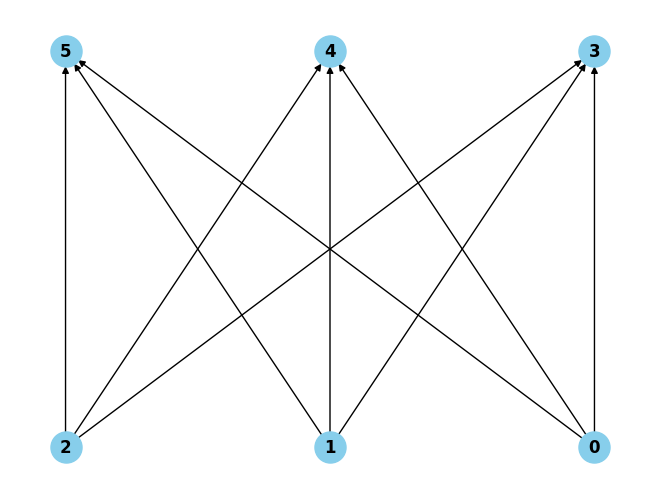

In [ ]:
TR_INPUT = 3
TR_OUTPUT = 3
topology = create_stratified_topology([TR_INPUT,TR_OUTPUT])
NeuralNetwork.display_topology(topology)

In [ ]:
topology

{0: ['input_0', None, [], [3, 4, 5]],
 1: ['input_0', None, [], [3, 4, 5]],
 2: ['input_0', None, [], [3, 4, 5]],
 3: ['output_1', 'identity', [], []],
 4: ['output_1', 'identity', [], []],
 5: ['output_1', 'identity', [], []]}

In [ ]:
NN = NeuralNetwork(topology, -0.75, 0.75, True, RANDOM_STATE)

In [ ]:
len_dataset = 1000
tr_df = create_dataset(len_dataset, TR_INPUT, [0, 10], 
                      [lambda x : -2*x[0] + x[1] + 3, # solo primi 2 input
                       lambda x : 3*x[0] + x[1]**2 - 3, # solo primi 2 input
                       lambda x : x[0] + x[1] + x[2] + 2], 
                      RANDOM_STATE)
tr_df.sample(10, random_state=RANDOM_STATE)

,input_1,input_2,input_3,output_1,output_2,output_3
144,0.246093,1.467228,8.994763,4.959414,6.462564,12.708084
833,7.450538,6.991663,4.891431,24.892739,-6.864119,21.333632
270,2.822279,1.024777,3.746948,9.669334,-1.929671,9.594003
468,7.825623,0.776977,2.740492,19.428224,-17.311404,13.343093
962,1.516672,3.647898,1.664358,9.681242,5.921832,8.828928
186,4.080822,1.847741,7.125555,13.009386,-4.470855,15.054119
942,3.644278,3.303550,1.868843,13.592105,-0.977508,10.816671
516,2.272989,7.597820,9.096001,15.143797,9.577763,20.966810
286,0.017921,6.869049,2.473152,9.904892,15.249811,11.360122
458,0.366532,6.672075,2.707836,10.405138,13.908517,11.746443


In [ ]:
scaler_out = MinMaxScaler()
scaler_in = MinMaxScaler()
scaler_in.fit(tr_df.values[:,:TR_INPUT])
scaler_out.fit(tr_df.values[:,TR_INPUT:])
tr_normalized = np.empty((len_dataset, TR_OUTPUT+TR_INPUT))
tr_normalized[:,:TR_INPUT] = scaler_in.transform(tr_df.values[:,:TR_INPUT])
tr_normalized[:,TR_INPUT:] = scaler_out.transform(tr_df.values[:,TR_INPUT:])

In [ ]:
tr_normalized
tr_df_normalized = pd.DataFrame(data = tr_normalized, columns=tr_df.columns)

In [ ]:
training_set = tr_df.values

batch_size = 100
max_epochs = 1000
error_decrease_tolerance = 0.0001
patience = 5

learning_rate = 0.01/batch_size
lambda_tikhonov = 0
alpha_momentum = 0

stats = NN.train(tr_normalized, batch_size, max_epochs, error_decrease_tolerance, patience, 
                   learning_rate, lambda_tikhonov, alpha_momentum)

In [ ]:
predictions_normalized = NN.predict_array(tr_normalized[:,:TR_INPUT])
predictions = scaler_out.inverse_transform(predictions_normalized)

In [ ]:
tr_df[['prediction_1', 'prediction_2', 'prediction_3']] = predictions
for col in ['prediction_1', 'prediction_2', 'prediction_3']:
    tr_df[col + '_err'] = (tr_df[col] - tr_df['output_' + col[-1]])**2
    tr_df[['prediction_1', 'prediction_2', 'prediction_3']] = predictions


tr_df_normalized[['prediction_1', 'prediction_2', 'prediction_3']] = predictions_normalized
for col in ['prediction_1', 'prediction_2', 'prediction_3']:
    tr_df_normalized[col + '_err'] = (tr_df_normalized[col] - tr_df_normalized['output_' + col[-1]])**2
    tr_df_normalized[['prediction_1', 'prediction_2', 'prediction_3']] = predictions_normalized

In [ ]:
for key in list(stats.keys())[:9]:
    print(key, ':', stats[key])

training_set_len : 1000
minibatch_size : 100
max_epochs : 1000
error_decrease_tolerance : 0.0001
patience : 5
learning_rate : 0.0001
lambda_tikhonov : 0
alpha_momentum : 0
epochs : 1000


In [ ]:
print('last training errors')
print(stats['training_error'][-10:])

last training errors
[1.0857403569601958e-06, 1.0753975677828872e-06, 1.0651539160879969e-06, 1.0550084420768305e-06, 1.0449601953912922e-06, 1.0350082350184835e-06, 1.025151629196684e-06, 1.0153894553223105e-06, 1.0057207998574075e-06, 9.961447582386945e-07]


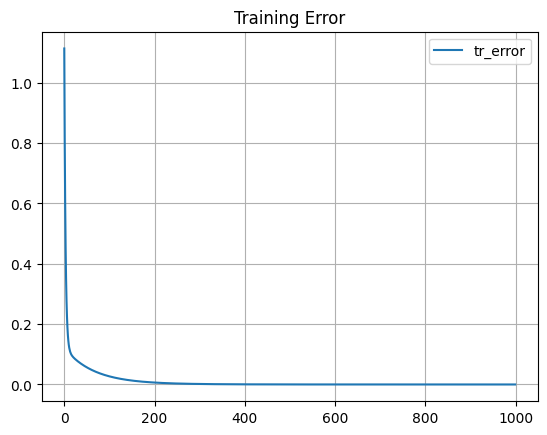

In [ ]:
multy_plot([stats['training_error']], ['tr_error'], 'Training Error')

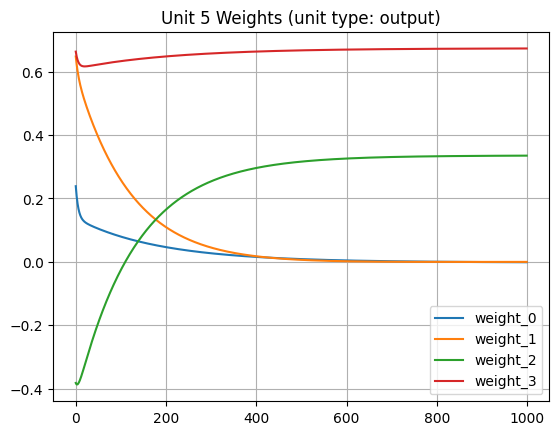

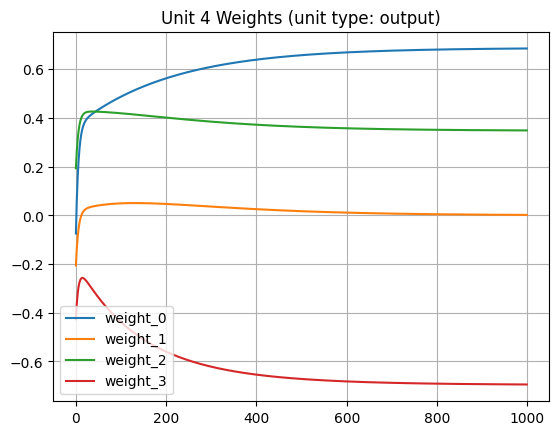

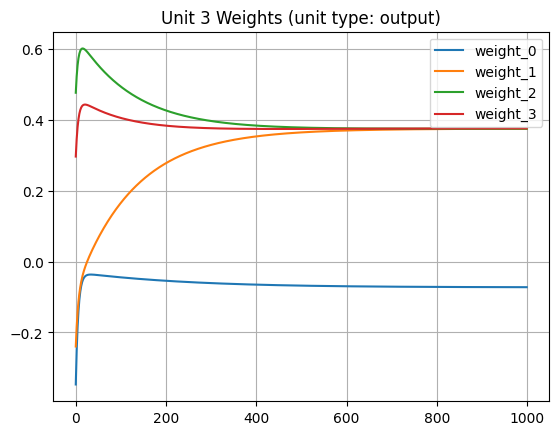

In [ ]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

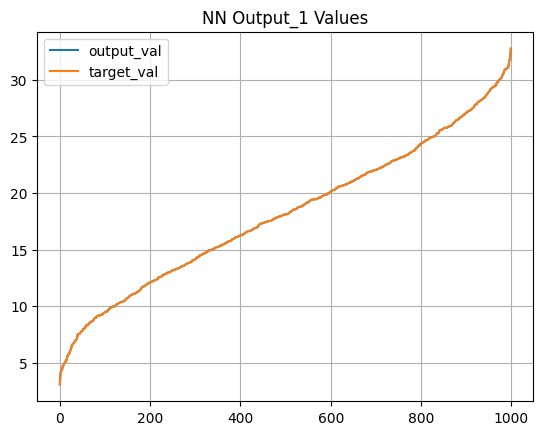

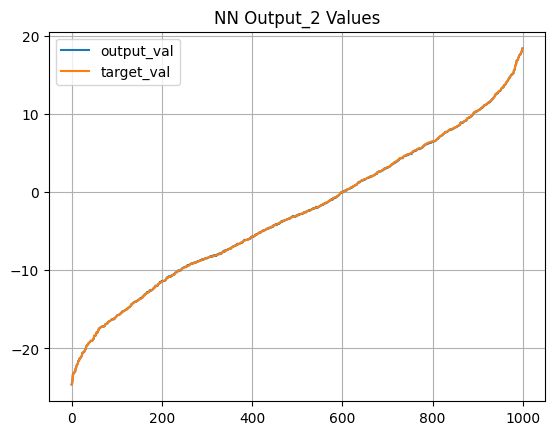

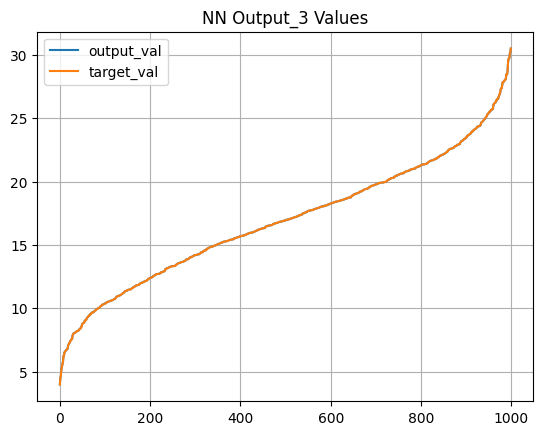

In [ ]:
for i in range(TR_INPUT):
    sorted_order = training_set[:, TR_INPUT + i].argsort()
    multy_plot([predictions[sorted_order][:,i] , training_set[sorted_order][:,TR_INPUT + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

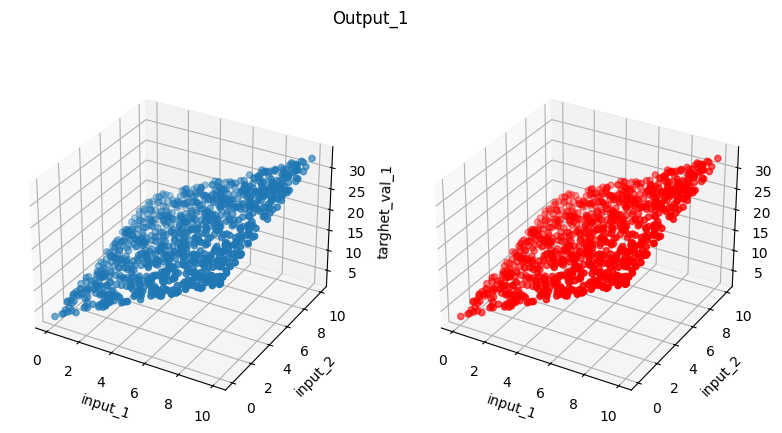

In [ ]:
fig = plt.figure(figsize=plt.figaspect(0.5))
fig.suptitle('Output_1')

ax = fig.add_subplot(1, 2, 1, projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(training_set[:,0], training_set[:,1], training_set[:,TR_INPUT], marker='o')
ax.set_xlabel('input_1')
ax.set_ylabel('input_2')
ax.set_zlabel('targhet_val_1')

ax = fig.add_subplot(1, 2, 2, projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(training_set[:,0], training_set[:,1], predictions[:,0], marker='o', color='red')
ax.set_xlabel('input_1')
ax.set_ylabel('input_2')
ax.set_zlabel('prediction_1')
plt.show()

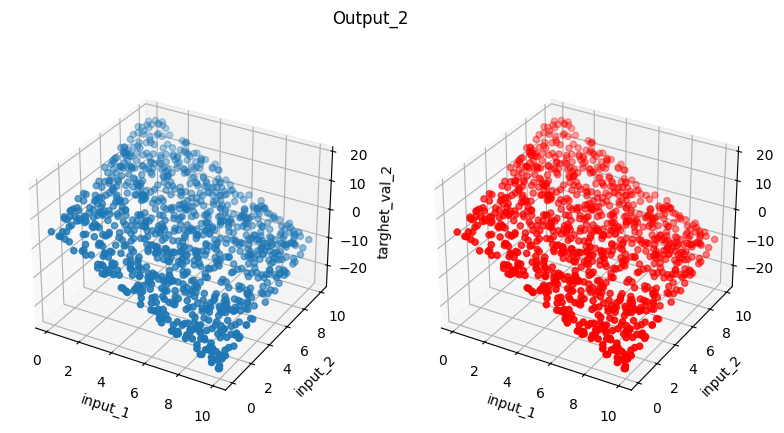

In [ ]:
fig = plt.figure(figsize=plt.figaspect(0.5))
fig.suptitle('Output_2')

ax = fig.add_subplot(1, 2, 1, projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(training_set[:,0], training_set[:,1], training_set[:,TR_INPUT + 1], marker='o')
ax.set_xlabel('input_1')
ax.set_ylabel('input_2')
ax.set_zlabel('targhet_val_2')

ax = fig.add_subplot(1, 2, 2, projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(training_set[:,0], training_set[:,1], predictions[:,1], marker='o', color='red')
ax.set_xlabel('input_1')
ax.set_ylabel('input_2')
ax.set_zlabel('prediction_2')
plt.show()

In [ ]:
df = px.data.iris()
fig = px.scatter_3d(tr_df_normalized, x='input_1', y='input_2', z='prediction_1',
              color='prediction_1_err', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
df = px.data.iris()
fig = px.scatter_3d(tr_df_normalized, x='input_1', y='input_2', z='prediction_2',
              color='prediction_2_err', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
NN = NeuralNetwork(topology_2, -0.75, 0.75, True, RANDOM_STATE)

tr_2 = create_dataset(len_dataset, tr_1_input, [0, 50, 1], [lambda x : -3*x[0] + x[1]**2 + 15, lambda x : 2*x[0] + 15*x[1] - 50], RANDOM_STATE)
tr_2.sample(10, random_state=RANDOM_STATE)

scaler_2_out = MinMaxScaler()
scaler_2_in = MinMaxScaler()
scaler_2_in.fit(tr_2.values[:,:2])
scaler_2_out.fit(tr_2.values[:,2:])
tr_2_normalized = np.empty((len_dataset, tr_1_output+tr_1_input))
tr_2_normalized[:,:2] = scaler_2_in.transform(tr_2.values[:,:2])
tr_2_normalized[:,2:] = scaler_2_out.transform(tr_2.values[:,2:])

training_set = tr_2.values
stats = NN.train_2(tr_2_normalized, batch_size, max_epochs, error_decrease_tolerance, patience, 
                   learning_rate, lambda_tikhonov, alpha_momentum)
predictions = scaler_2_out.inverse_transform(NN.predict_array(tr_2_normalized[:,:2]))

NameError: name 'topology_2' is not defined

In [ ]:
for key in list(stats.keys())[:9]:
    print(key, ':', stats[key])

training_set_len : 1000
minibatch_size : 100
max_epochs : 1000
error_decrease_tolerance : 0.0001
patience : 5
learning_rate : 0.0001
lambda_tikhonov : 0
alpha_momentum : 0
epochs : 628


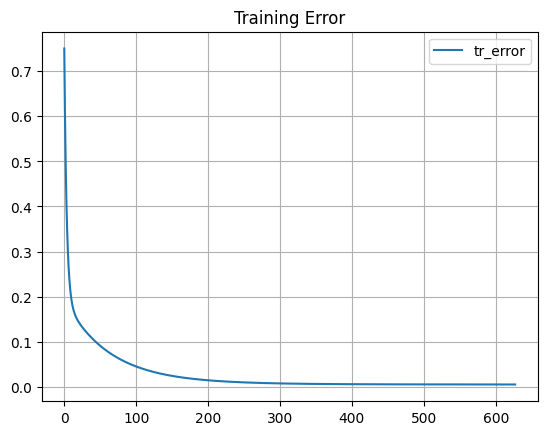

In [ ]:
multy_plot([stats['training_error']], ['tr_error'], 'Training Error')

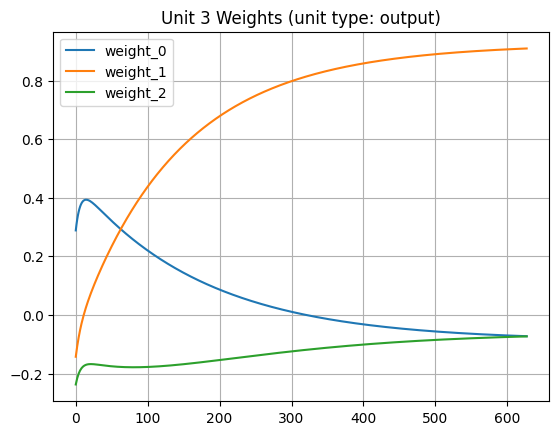

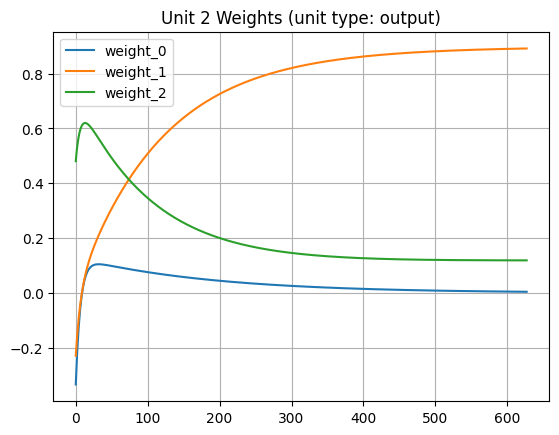

In [ ]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

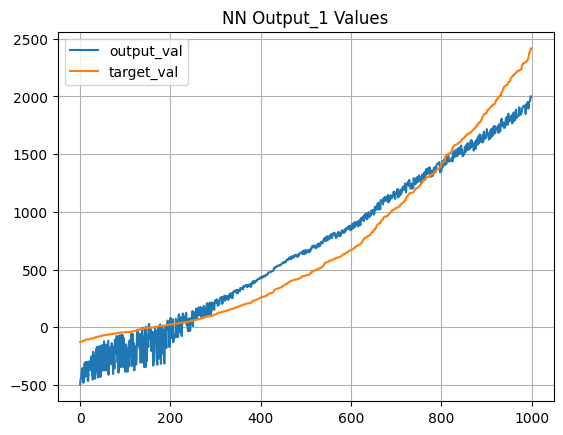

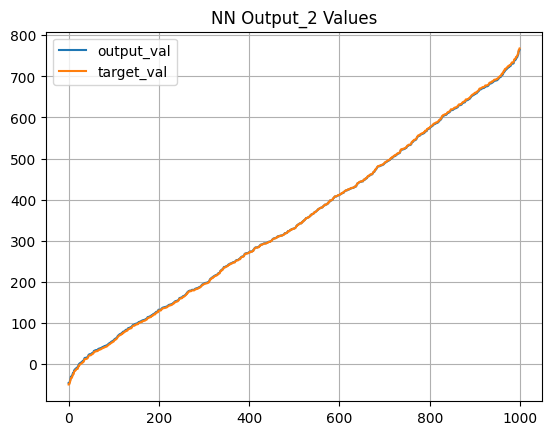

In [ ]:
for i in range(tr_1_output):
    sorted_order = training_set[:, tr_1_input + i].argsort()
    multy_plot([predictions[sorted_order][:,i] , training_set[sorted_order][:,tr_1_input + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')